# 1. Librerie

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-06-06 19:59:17.023836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Import Neural Network

In [3]:
#Importazione del modello
actions = np.array(['0','1', '2', '3','4','5','altro'])
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(126,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.load_weights('modello/action.h5')

# 3. Definizione delle funzioni 

In [4]:
mp_holistic = mp.solutions.holistic

def mediapipe_detection(image, model):

    """
    Esegue la rilevazione dei landmark delle mani utilizzando il modello di MediaPipe.

    Input:
    - image: l'immagine di input (frame) su cui effettuare la rilevazione dei landmark
    - model: il modello di MediaPipe per la rilevazione dei landmark

    Output:
    - image: l'immagine di input modificata, con i landmark disegnati
    - results: gli oggetti 'results' contenenti i risultati della rilevazione dei landmark
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):

    """
    Estrae i punti chiave dei landmark della mano sinistra e destra dagli oggetti 'results'.

    Input:
    - results: gli oggetti 'results' ottenuti dall'elaborazione dell'immagine con MediaPipe

    Output:
    - keypoints: array numpy contenente i punti chiave dei landmark delle mani
    """

    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #estrae i punti chiave dei landmark della mano sinistra
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

def extract_hand_landmark_coordinates(image, results):

    """
    Estrae le coordinate dei landmark della mano sinistra e destra dall'oggetto 'results'.

    Input:
    - image: l'immagine di input
    - results: gli oggetti 'results' ottenuti dall'elaborazione dell'immagine con MediaPipe

    Output:
    - right_hand_landmark_coordinates: lista delle coordinate dei landmark per la mano destra
    - left_hand_landmark_coordinates: lista delle coordinate dei landmark per la mano sinistra
    """
     
    left_hand_landmarks = results.left_hand_landmarks # Estrae le coordinate dei landmark della mano sinistra dall'oggetto 'results'
    right_hand_landmarks = results.right_hand_landmarks # Estrae le coordinate dei landmark della mano destra dall'oggetto 'results'

    # Inizializza le liste per le coordinate dei landmark
    left_hand_landmark_coordinates = []
    right_hand_landmark_coordinates = []

    # Estrae le coordinate dei landmark per la mano sinistra, se presenti
    if left_hand_landmarks:
        for landmark in left_hand_landmarks.landmark:
            
            x = int(landmark.x * image.shape[1]) # Calcola le coordinate x e y in pixel
            y = int(landmark.y * image.shape[0])
            z = landmark.z # Estrae la coordinata z
            
            left_hand_landmark_coordinates.append((x, y, z)) # Aggiunge le coordinate alla lista

    # Estrae le coordinate dei landmark per la mano destra, se presenti
    if right_hand_landmarks:
        for landmark in right_hand_landmarks.landmark:
            
            x = int(landmark.x * image.shape[1]) # Calcola le coordinate x e y in pixel
            y = int(landmark.y * image.shape[0])      
            z = landmark.z # Estrae la coordinata z
            
            right_hand_landmark_coordinates.append((x, y, z)) # Aggiunge le coordinate alla lista
    return right_hand_landmark_coordinates, left_hand_landmark_coordinates



def extract_real_z_values(hand_landmark_coordinates, depth_map, depth_unity=0.000125):
    """
    Estrae i valori di profondità reali e predetti dalla mappa di profondità per i landmark della mano.

    Input:
    - hand_landmark_coordinates: le coordinate dei landmark della mano
    - depth_map: la mappa di profondità
    - depth_unity: il fattore di scala per convertire i valori di profondità in metri (default: 0.000125)

    Output:
    - real_z_values: una lista contenente i valori di profondità reali in metri
    - predicted_z_values: una lista contenente i valori di profondità predetti in metri
    """

    real_z_values = []  # Lista per i valori di profondità reali
    predicted_z_values = []  # Lista per i valori di profondità predetti

    if hand_landmark_coordinates:
        # Calcolo della distanza reale del polso
        depth_polso = depth_map[hand_landmark_coordinates[0][1], hand_landmark_coordinates[0][0]] * depth_unity
    else:
        depth_polso = 0

    # Iterazione sui landmark della mano
    for x, y, z in hand_landmark_coordinates:
        # Z REALE
        depth = depth_map[y, x]  # Valore di profondità dalla mappa
        real_z = depth * depth_unity  # Calcolo del valore di profondità reale in metri
        real_z_values.append(real_z)  # Aggiunta del valore alla lista dei valori reali

        # Z PREDETTA
        predicted_z = depth_polso + z  # Calcolo del valore di profondità predetto sommando la profondità del polso reale alla coordinata Z prevista da MediaPipe
        predicted_z_values.append(predicted_z)  # Aggiunta del valore alla lista dei valori predetti

    return real_z_values, predicted_z_values


def evaluate_accuracy(predicted_values, ground_truth_values):
    """
    Valuta l'accuratezza delle previsioni confrontando i valori previsti con i valori di verità.

    Input:
    - predicted_values: i valori previsti
    - ground_truth_values: i valori di verità

    Output:
    - rmse: la radice dell'errore quadratico medio (Root Mean Squared Error)
    - mae: l'errore medio assoluto (Mean Absolute Error)
    """

    rmse = np.sqrt(mean_squared_error(ground_truth_values, predicted_values))  # Calcolo dell'RMSE
    mae = mean_absolute_error(ground_truth_values, predicted_values)  # Calcolo dell'MAE
    return rmse, mae

Funzioni per il plotting dei risultati

In [5]:
def plot_error_landmark(predicted_value, ground_truth_values):
    """
    Plotta l'errore medio e la deviazione standard per ciascun landmark.

    Input:
    - predicted_value: i valori previsti
    - ground_truth_values: i valori del ground truth

    Output:
    - None
    """

    # Conversione delle liste in array numpy, se necessario
    if isinstance(predicted_value, list):
        predicted_value = np.array(predicted_value)
    if isinstance(ground_truth_values, list):
        ground_truth_values = np.array(ground_truth_values)

    mean_errors = []  # Lista degli errori medi
    std_errors = []  # Lista delle deviazioni standard

    # Calcolo dell'errore medio e della deviazione standard per ciascun landmark
    for i in range(len(predicted_value)):
        errors = np.abs(predicted_value[i] - ground_truth_values[i])  # Calcolo degli errori
        mean_error = np.mean(errors)  # Calcolo dell'errore medio
        std_error = np.std(errors)  # Calcolo della deviazione standard
        mean_errors.append(mean_error)
        std_errors.append(std_error)

    # Creazione di una nuova figura
    plt.figure()

    # Plotting
    landmarks = range(len(mean_errors))
    plt.bar(landmarks, mean_errors, align='center', alpha=0.5, yerr=std_errors)
    plt.xticks(landmarks)
    plt.xlabel('Landmark')
    plt.ylabel('Mean Error')
    plt.title('Mean Error and Standard Deviation per Landmark')
    plt.show()

# 4.1. CALCOLO DELL'ACCURACY SU UN SINGOLO FRAME

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


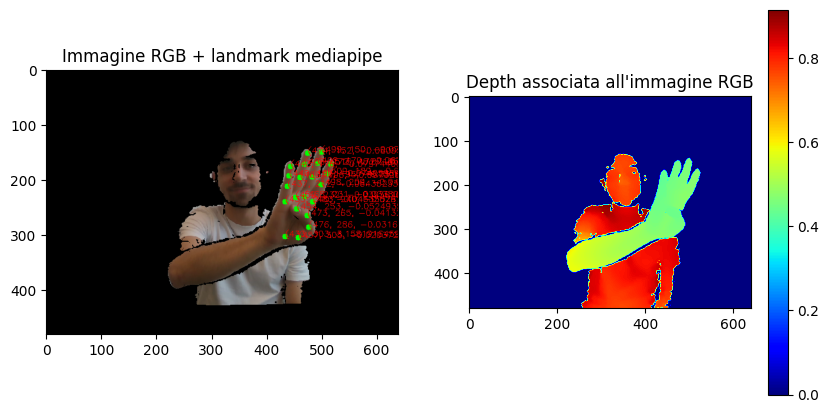

RMSE = 0.04254479802617921
MAE = 0.037767310293136166


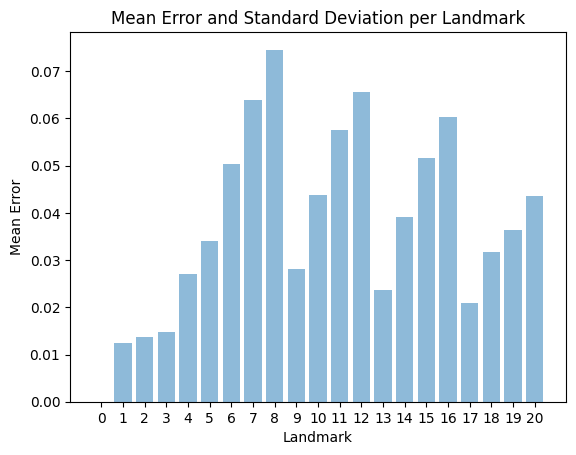

In [6]:
rgb_image = cv2.imread('Frame Depth/4/marco_38859_dx.png') # Carica l'immagine RGB
depth_map = np.fromfile('Frame Depth/4/marco_38859_dx_Depth.raw', dtype=np.uint16) # Carica la mappa di profondità RAW come array numpy

#Poiché il formato è "Z16" (16 bit di profondità), possiamo utilizzare il tipo di dati numpy 
# "np.float16" per rappresentare i valori di profondità.

image_height, image_width, _ = rgb_image.shape #estrae la dimensione dell'immagine rgb

depth_map = depth_map.reshape(image_height, image_width) # Ridimensiona la mappa di profondità all'altezza e larghezza dell'immagine RGB


# Carica il modello di MediaPipe per il rilevamento delle mani
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    image, results = mediapipe_detection(rgb_image, holistic) # Effettua la rilevazione delle mani con MediaPipe

    #Per verificare visivamente la presenza di landmark prima dell'estrazione delle coordinate
    # Draw landmarks
    """draw_styled_landmarks(image, results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))"""

    # Estrai le coordinate dei landmark della mano destra e sinistra
    right_hand_landmark_coordinates, left_hand_landmark_coordinates = extract_hand_landmark_coordinates(image,results)

    # Creazione della figura e dei subplot per le due immagini
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    #Per verificare visivamente la presenza di landmark dopo dell'estrazione delle coordinate
    for landmark in left_hand_landmark_coordinates:
        x, y, z = landmark
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Disegna un cerchio verde intorno al landmark
        cv2.putText(image, f"({x}, {y}, {z})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Mostra le coordinate
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for landmark in right_hand_landmark_coordinates:
        x, y, z = landmark
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Disegna un cerchio verde intorno al landmark
        cv2.putText(image, f"({x}, {y}, {z})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Mostra le coordinate
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    ax1.set_title('Immagine RGB + landmark mediapipe')

    # Mostra l'immagine della depth nel secondo subplot
    ax2.imshow(depth_map, cmap='gray')
    ax2.set_title('Depth associata all\'immagine RGB')
    depth_unity=0.000125
    im = ax2.imshow(depth_map * depth_unity, cmap='jet') # Visualizza l'immagine di profondità con una scala di colore
    
    # Aggiungi una barra dei colori al subplot della depth
    fig.colorbar(im, ax=ax2)

    # Visualizza la figura
    plt.show()

    # Estrai i valori di z reali e predetta dalla mappa di profondità per la mano destra
    real_z_values_right, predicted_z_values_right = extract_real_z_values(right_hand_landmark_coordinates, depth_map)

    # Estrai i valori di z reali e predetta dalla mappa di profondità per la mano sinistra
    real_z_values_left, predicted_z_values_left = extract_real_z_values(left_hand_landmark_coordinates, depth_map)


    # Calcola l'accuratezza
    rmse,mae = evaluate_accuracy(predicted_z_values_right, real_z_values_right)
    print(f"RMSE = {rmse}")
    print(f"MAE = {mae}")
    plot_error_landmark(predicted_z_values_right,real_z_values_right)


Sovrapposizione dell'immagine RGB e Depth

In [7]:
# Definisci la funzione di callback del mouse
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        z = depth_map[y, x] * depth_unity
        overlay_image = np.copy(output_image)
        cv2.putText(overlay_image, f'Z: {z}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.imshow('RGB Image with Depth', overlay_image)
    else:
        cv2.imshow('RGB Image with Depth', output_image)

# Crea un'immagine vuota per l'overlay
overlay_image = np.zeros_like(rgb_image)

# Copia l'immagine RGB nell'overlay
np.copyto(overlay_image, rgb_image)

# Moltiplica la depth map per depth_unity per ripristinare i valori originali
depth_map_scaled = depth_map * depth_unity

# Combina l'immagine RGB e l'overlay utilizzando l'operazione bitwise OR
output_image = cv2.bitwise_or(rgb_image, overlay_image)

# Crea una finestra per l'immagine risultante
cv2.namedWindow('RGB Image with Depth')

# Imposta la funzione di callback del mouse per la finestra
cv2.setMouseCallback('RGB Image with Depth', mouse_callback)

# Visualizza l'immagine risultante
cv2.imshow('RGB Image with Depth', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# 4.2. CALCOLO DELL'ACCURACY SU TUTTI I FRAME (CON TABELLA RIASSUNTIVA)

In [15]:
def process_folder(folder_path):

    """
    Elabora una cartella specifica, analizzando i file al suo interno e generando una tabella con informazioni sulla rilevazione delle mani, valori di profondità e classificazione delle azioni.

    Input:
        folder_path (str): Il percorso della cartella da elaborare.

    Output:
        None: La funzione stampa una tabella con le informazioni elaborate.
    """

    # Prendi tutti i file all'interno della cartella
    files = os.listdir(folder_path)
    gesto = folder_path.split("/")[-1]

    # Inizializza la tabella
    table = PrettyTable()
    table.field_names = ['Frame', 'RMSE Sinistra', 'MAE Sinistra', 'RMSE Destra', 'MAE Destra', 'RILEVAMENTO MEDIAPIPE','classe reale','classe predetta']

    # Liste per memorizzare i valori di RMSE e MAE per ogni gesto
    rmse_values = []
    mae_values = []

    # Loop attraverso tutti i file nella cartella
    for file in files:
        if file.endswith(".png"):
            # Verifica se il file corrisponde a un'immagine
            if re.search(r'_\d+_(?:dx|sx)\.png', file):
                # Costruisci il percorso completo dell'immagine RGB
                rgb_image_path = os.path.join(folder_path, file)

                # Esegui il caricamento dell'immagine RGB
                rgb_image = cv2.imread(rgb_image_path)

                # Costruisci il percorso completo della mappa di profondità RAW
                depth_map_path = os.path.join(folder_path, f"{file}_Depth.raw")

                # Carica la mappa di profondità RAW come array numpy
                filename_without_extension = os.path.splitext(file)[0]
                depth_map_path = os.path.join(folder_path, f"{filename_without_extension}_Depth.raw")
                depth_map = np.fromfile(depth_map_path, dtype=np.uint16)

                image_height, image_width, _ = rgb_image.shape
                depth_map = depth_map.reshape(image_height, image_width)

                # Carica il modello di MediaPipe per il rilevamento delle mani
                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    image, results = mediapipe_detection(rgb_image, holistic)
                    
                    keypoints = extract_keypoints(results)
                    res = model.predict(np.expand_dims(keypoints, axis=0),verbose=0)[0]
                    res = actions[np.argmax(res)]

                    right_hand_landmark_coordinates, left_hand_landmark_coordinates = extract_hand_landmark_coordinates(image,results)

                    # Estrai i valori di z reali e predetti dalla mappa di profondità per la mano destra
                    if len(right_hand_landmark_coordinates) > 0:
                        real_z_values_right, predicted_z_values_right = extract_real_z_values(right_hand_landmark_coordinates, depth_map)
                        rmse_right, mae_right = evaluate_accuracy(predicted_z_values_right[1:], real_z_values_right[1:])
                    else:
                        rmse_right = "Mano non presente"
                        mae_right = "Mano non presente"

                    # Estrai i valori di z reali e predetti dalla mappa di profondità per la mano sinistra
                    if len(left_hand_landmark_coordinates) > 0:
                        real_z_values_left, predicted_z_values_left = extract_real_z_values(left_hand_landmark_coordinates, depth_map)
                        rmse_left, mae_left = evaluate_accuracy(predicted_z_values_left[1:], real_z_values_left[1:])
                    else:
                        rmse_left = "Mano non presente"
                        mae_left = "Mano non presente"
                    
                    # Aggiungi i valori di RMSE e MAE alla lista corrispondente (escludendo i valori "Mano non presente")
                    if rmse_left != "Mano non presente":
                        rmse_values.append(rmse_left)
                        mae_values.append(mae_left)

                    if rmse_right != "Mano non presente":
                        rmse_values.append(rmse_right)
                        mae_values.append(mae_right)

                    # Determina se il rilevamento di MediaPipe è stato effettuato correttamente
                    if rmse_left == "Mano non presente" and mae_left == "Mano non presente" and rmse_right == "Mano non presente" and mae_right == "Mano non presente":
                        rilevamento_mediapipe = "NO"
                    else:
                        rilevamento_mediapipe = "SI"

                    # Aggiungi una riga alla tabella
                    table.add_row([file, rmse_left, mae_left, rmse_right, mae_right, rilevamento_mediapipe, gesto,res])

    # Calcola le medie di RMSE e MAE per il gesto corrente
    rmse_avg = np.mean(rmse_values)
    mae_avg = np.mean(mae_values)

    # Aggiungi una riga alla tabella per mostrare le medie di RMSE e MAE
    table.add_row(['Media', rmse_avg, mae_avg, '', '', '', '', ''])

    # Stampa la tabella
    print(table)

    return rmse_avg, mae_avg

In [16]:
# Liste per memorizzare le medie di RMSE e MAE per tutti i gesti
avg_rmse_values = []
avg_mae_values = []

# Cartelle contenenti i gesti
gesture_folders = ["Frame Depth/0", "Frame Depth/1", "Frame Depth/2", "Frame Depth/3", "Frame Depth/4","Frame Depth/5"]

# Creazione del DataFrame per la tabella principale
main_table = pd.DataFrame()

# Loop attraverso le cartelle dei gesti
for folder in gesture_folders:
    rmse_avg, mae_avg = process_folder(folder)

    # Aggiungi le medie di RMSE e MAE alle liste
    avg_rmse_values.append(rmse_avg)
    avg_mae_values.append(mae_avg)


+----------------------+---------------------+---------------------+----------------------+----------------------+-----------------------+--------------+-----------------+
|        Frame         |    RMSE Sinistra    |     MAE Sinistra    |     RMSE Destra      |      MAE Destra      | RILEVAMENTO MEDIAPIPE | classe reale | classe predetta |
+----------------------+---------------------+---------------------+----------------------+----------------------+-----------------------+--------------+-----------------+
| giovanni_1164_dx.png |  Mano non presente  |  Mano non presente  |  Mano non presente   |  Mano non presente   |           NO          |      0       |      altro      |
|  alice_31798_sx.png  | 0.18260357471023544 | 0.09530194924226525 |  Mano non presente   |  Mano non presente   |           SI          |      0       |        0        |
|  sara_11175_dx.png   |  Mano non presente  |  Mano non presente  | 0.16973843036488603  | 0.08203632541743573  |           SI          |  

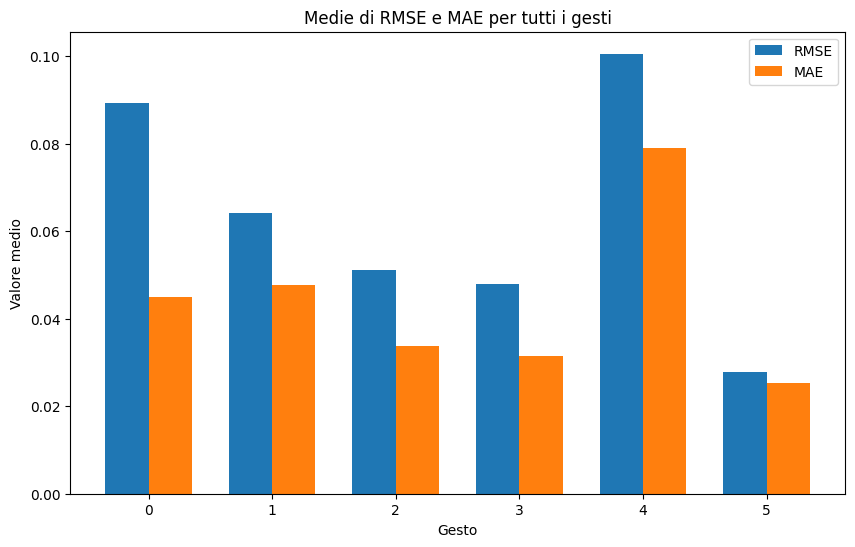

In [17]:
# Crea un grafico ad istogramma per visualizzare le medie di RMSE e MAE per tutti i gesti
plt.figure(figsize=(10, 6))
x = np.arange(len(actions)-1)
width = 0.35
plt.bar(x - width/2, avg_rmse_values, width, label='RMSE')
plt.bar(x + width/2, avg_mae_values, width, label='MAE')
plt.xlabel('Gesto')
plt.ylabel('Valore medio')
plt.title('Medie di RMSE e MAE per tutti i gesti')
plt.xticks(x, actions[0:-1])
plt.legend()
plt.show()